# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python
!pip install unityagents

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
#from UnityEnvironment import UnityEnvironment
import numpy as np
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [19]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:

import torch
from collections import deque
from matplotlib import pyplot as plt

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

#Actor network
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, input_size, output_size, seed, fc1_units=256, fc2_units=256):
         """Initialize parameters and build actor model.
        Params
        ======
            input_size (int):  number of dimensions for input layer
            output_size (int): number of dimensions for output layer
            seed (int): random seed
            fc1_units (int): number of nodes in first hidden layer
            fc2_units (int): number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_size)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights with near zero values."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor network that maps states to actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.leaky_relu(self.fc1(state))
        x = self.bn(x)
        x = F.leaky_relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

#Critic network 
class Critic(nn.Module):

    def __init__(self, input_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
            input_size (int): number of dimensions for input layer
            seed (int): random seed
            fc1_units (int): number of nodes in the first hidden layer
            fc2_units (int): number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights with near zero values."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic network that maps (states, actions) pairs to Q-values."""
        xs = torch.cat((states, actions), dim=1)
        x = F.leaky_relu(self.fc1(xs))
        x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

#Creation of the 4 networks 
class Actor_Critic_Models():

    def __init__(self, n_agents, state_size=24, action_size=2, seed=0):
        """
        Params
        ======
            n_agents (int): number of agents
            state_size (int): number of state dimensions for a single agent
            action_size (int): number of action dimensions for a single agent
            seed (int): random seed
        """
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        critic_input_size = (state_size+action_size)*n_agents
        self.critic_local = Critic(critic_input_size, seed).to(device)
        self.critic_target = Critic(critic_input_size, seed).to(device)

In [12]:
import random
import copy
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MADDPG():
    """Meta agent that contains the two DDPG agents and shared replay buffer."""

    def __init__(self, action_size=2, seed=0, 
                 n_agents=2,
                 buffer_size=10000,
                 batch_size=256,
                 gamma=0.99,
                 update_every=2,
                 noise_start=1.0,
                 noise_decay=1.0,
                 t_stop_noise=30000):
        
        """
        Params
        ======
            action_size (int): dimension of each action
            seed (int): Random seed
            n_agents (int): number of distinct agents
            buffer_size (int): replay buffer size
            batch_size (int): minibatch size
            gamma (float): discount factor
            noise_start (float): initial noise weighting factor
            noise_decay (float): noise decay rate
            update_every (int): how often to update the network
            t_stop_noise (int): max number of timesteps with noise applied in training
        """

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.n_agents = n_agents
        self.noise_weight = noise_start
        self.noise_decay = noise_decay
        self.t_step = 0
        self.noise_on = True
        self.t_stop_noise = t_stop_noise

        # create two agents, each with their own actor and critic
        models = [Actor_Critic_Models(n_agents=n_agents) for _ in range(n_agents)]
        self.agents = [DDPG(i, models[i]) for i in range(n_agents)]
        
        # create shared replay buffer
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)

    def step(self, all_states, all_actions, all_rewards, all_next_states, all_dones):
        all_states = all_states.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        all_next_states = all_next_states.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        self.memory.add(all_states, all_actions, all_rewards, all_next_states, all_dones)
        
        # if t_stop_noise time steps are achieved turn off noise
        if self.t_step > self.t_stop_noise:
            self.noise_on = False
        
        self.t_step = self.t_step + 1     
        # Learn every update_every time steps.
        if self.t_step % self.update_every == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                # sample from the replay buffer for each agent
                experiences = [self.memory.sample() for _ in range(self.n_agents)]
                self.learn(experiences, self.gamma)

    def act(self, all_states,currepisode, add_noise=True):
        # pass each agent's state from the environment and calculate its action
        all_actions = []
        for agent, state in zip(self.agents, all_states):
            action = agent.act(state,currepisode, noise_weight=self.noise_weight, add_noise=self.noise_on)
            self.noise_weight *= self.noise_decay
            all_actions.append(action)
        return np.array(all_actions).reshape(1, -1) # reshape 2x2 into 1x4 dim vector

    def learn(self, experiences, gamma):
        # each agent uses its own actor to calculate next_actions
        all_next_actions = []
        all_actions = []
        for i, agent in enumerate(self.agents):
            states, _, _, next_states, _ = experiences[i]
            agent_id = torch.tensor([i]).to(device)
            # extract agent i's state and get action via actor network
            state = states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            action = agent.actor_local(state)
            all_actions.append(action)
            # extract agent i's next state and get action via target actor network
            next_state = next_states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            next_action = agent.actor_target(next_state)
            all_next_actions.append(next_action)
                       
        # each agent learns from its experience sample
        for i, agent in enumerate(self.agents):
            agent.learn(i, experiences[i], gamma, all_next_actions, all_actions)
            
    def save_agents(self):
        # save models for local actor and critic of each agent
        for i, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(),  f"checkpoint_actor_agent_{i}.pth")
            torch.save(agent.critic_local.state_dict(), f"checkpoint_critic_agent_{i}.pth")


class DDPG():
    """DDPG agent with own actor and critic."""

    def __init__(self, agent_id, model, action_size=2, seed=0,
                 tau=1e-3,
                 lr_actor=1e-4,
                 lr_critic=1e-3,
                 weight_decay=0.0):
        
        """
        Params
        ======
            model: model object
            action_size (int): dimension of each action
            seed (int): Random seed
            tau (float): for soft update of target parameters
            lr_actor (float): learning rate for actor
            lr_critic (float): learning rate for critic
            weight_decay (float): L2 weight decay
        """
        random.seed(seed)
        self.id = agent_id
        self.action_size = action_size
        self.tau = tau
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
       
        # Actor Network
        self.actor_local = model.actor_local
        self.actor_target = model.actor_target
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)
        
        # Critic Network
        self.critic_local = model.critic_local
        self.critic_target = model.critic_target
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic, weight_decay=weight_decay)
        
        # Set weights for local and target actor, respectively, critic the same
        self.hard_copy_weights(self.actor_target, self.actor_local)
        self.hard_copy_weights(self.critic_target, self.critic_local)
        
        # Noise process
        self.noise = OUNoise(action_size, seed)

    def hard_copy_weights(self, target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    
    def act(self, state,numepisode, noise_weight=1.0, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        # calculate action values
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            #self.noise_val = self.noise.sample() * noise_weight           
            self.noise_val = self.noise.sample() * noise_weight
            action += self.noise_val
            #action += (self.noise.sample()/np.sqrt(numepisode))  
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, agent_id, experiences, gamma, all_next_actions, all_actions):
        """Update policy and value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
            all_next_actions (list): each agent's next_action (as calculated by its actor)
            all_actions (list): each agent's action (as calculated by its actor)
        """

        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # get predicted next-state actions and Q values from target models
        self.critic_optimizer.zero_grad()
        agent_id = torch.tensor([agent_id]).to(device)
        actions_next = torch.cat(all_next_actions, dim=1).to(device)
        with torch.no_grad():
            q_targets_next = self.critic_target(next_states, actions_next)
        # compute Q targets for current states (y_i)
        q_expected = self.critic_local(states, actions)
        # q_targets = reward of this timestep + discount * Q(st+1,at+1) from target network
        q_targets = rewards.index_select(1, agent_id) + (gamma * q_targets_next * (1 - dones.index_select(1, agent_id)))
        # compute critic loss
        critic_loss = F.mse_loss(q_expected, q_targets.detach())
        # minimize loss
        critic_loss.backward()
        
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # compute actor loss
        self.actor_optimizer.zero_grad()
        # detach actions from other agents
        actions_pred = [actions if i == self.id else actions.detach() for i, actions in enumerate(all_actions)]
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # minimize loss
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        random.seed(seed)
        np.random.seed(seed)
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state


class ReplayBuffer():
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): Random seed
        """
        random.seed(seed)
        np.random.seed(seed)
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
def Train_MADDPGNetwork(env,brain_name,agent,num_agents,num_episodes=5000,max_timesteps=1000,print_every=100,train_mode=True):
    
    scores = []
    scores_deque = deque(maxlen=100)
    scores_avg = []
    
    
    for episode in range(1, num_episodes+1):
        scorestab = np.zeros(num_agents)  # initialize the score (for each agent)
        rewardslist = []
        env_info = env.reset(train_mode=False)[brain_name]  # reset the environment    
        states = env_info.vector_observations      # get the current state (for each agent)

        # loop over steps
        for t in range(max_timesteps):
            # select an action
            actions = agent.act(states,episode)
            # take action in environment and set parameters to new values
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scorestab += env_info.rewards    # update the score (for each agent)
            # update and train agent with returned information
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            rewardslist.append(rewards)
            if np.any(dones):
                break

        # calculate episode reward as maximum of individually collected rewards of agents
        episode_reward = np.max(np.sum(np.array(rewardslist),axis=0))
        
        scores.append(episode_reward)             # save most recent score to overall score array
        scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
        current_avg_score = np.mean(scores_deque)
        scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(episode, current_avg_score),end="")
        
        # log average score every 100 episodes
        if episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(episode, current_avg_score))
            print("\n")
            print('Score (max over agents) from episode {}: {}'.format(episode, np.max(scorestab)))
            print("\n")
       
        # break and report success if environment is solved
        if np.mean(scores_deque)>=.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(episode, np.mean(scores_deque)))
            agent.save_agents()
            break
    
    return scores

In [13]:

print(type(env))
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]  
print(type(brain_name))
print(brain_name)    
print(brain)
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
    
MADDPG_Agent = MADDPG(seed=2, noise_start=0.5, update_every=2, gamma=0.99, t_stop_noise=30000)   
print(type(MADDPG_Agent))
training_scores = Train_MADDPGNetwork(env,brain_name,MADDPG_Agent,num_agents)
    
    

<class 'unityagents.environment.UnityEnvironment'>
<class 'str'>
TennisBrain
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -7.0517621  -1.5        -0.          0.
 -7.11741829  5.94114017 -0.          0.        ]
<class '__main__.MADDPG'>
Episode 100	Average Score: 0.008


Score (max over agents) from episode 100: 0.0


Episode 200	Average Score: 0.019


S

In [ ]:
############### Results################################################

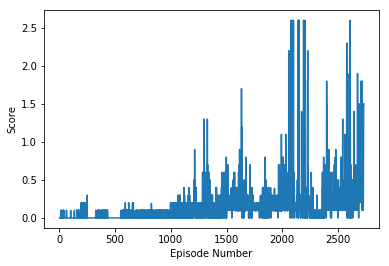

In [14]:

#plotting the scores
fig = plt.figure()
ax= fig.add_subplot()
plt.plot(np.arange(1,len(training_scores) + 1),training_scores)
plt.ylabel('Score')
plt.xlabel('Episode Number')
plt.show()